In [2]:
import pandas as pd

df=pd.read_csv("/content/movies_with_images_final.csv")
df.head()

,id,title,overview,genres,cast,director,keywords,rating,vote_count,release_date,imdb_rating,imdb_votes,poster_url,backdrop_url
0,533533,TRON: Ares,A highly sophisticated Program called Ares is ...,"['Science Fiction', 'Adventure', 'Action']","['Jared Leto', 'Greta Lee', 'Evan Peters', 'Gi...",Joachim Rønning,"['artificial intelligence (a.i.)', 'computer p...",6.548,656,2025-10-08,NaN,NaN,https://image.tmdb.org/t/p/w500/chpWmskl3aKm1a...,https://image.tmdb.org/t/p/w500/min9ZUDZbiguTi...
1,1180831,Troll 2,When a dangerous new troll unleashes devastati...,"['Action', 'Fantasy', 'Thriller']","['Ine Marie Wilmann', 'Kim S. Falck-Jørgensen'...",Roar Uthaug,"['mythical creature', 'sequel', 'troll', 'kaij...",6.800,218,2025-11-30,NaN,NaN,https://image.tmdb.org/t/p/w500/p6xAExLNFbHcLf...,https://image.tmdb.org/t/p/w500/lZYMXx74pWmbj5...
2,1083637,Kantara - A Legend: Chapter 1,"During the Kadamba reign, King Vijayendra, the...","['Action', 'Drama', 'Fantasy']","['Rishab Shetty', 'Rukmini Vasanth', 'Jayaram'...",Rishab Shetty,[],6.957,46,2025-10-01,NaN,NaN,https://image.tmdb.org/t/p/w500/zBvw25afDn93em...,https://image.tmdb.org/t/p/w500/w57nxiBIODAYHL...
3,23527,First Squad: The Moment of Truth,Set during the opening days of World War II on...,"['Fantasy', 'Animation', 'Action', 'Science Fi...","['Sergei Aisman', 'Michael Beskorovainy', 'Ele...",Yoshiharu Ashino,"['supernatural', 'super soldier', 'russian army']",6.200,129,2009-05-13,NaN,NaN,https://image.tmdb.org/t/p/w500/hBj1aTnGf4564K...,https://image.tmdb.org/t/p/w500/3k1PKmzNEosWFa...
4,1448560,Wildcat,An ex-black ops team reunite to pull off a des...,"['Action', 'Thriller', 'Crime']","['Kate Beckinsale', 'Lewis Tan', 'Alice Krige'...",James Nunn,"['playful', 'embarrassed']",5.838,34,2025-11-19,NaN,NaN,https://image.tmdb.org/t/p/w500/h893ImjM6Fsv5D...,https://image.tmdb.org/t/p/w500/pAyImoslSnpMgj...


In [3]:
df = df.dropna(subset=["overview", "genres", "cast", "director", "keywords"])
print("After cleaning:", df.shape)


After cleaning: (1635, 14)


In [4]:
import unicodedata

def normalize_text(t):
    if not isinstance(t, str):
        return ""
    t = unicodedata.normalize('NFKD', t).encode('ascii','ignore').decode('utf-8')
    return t.lower().strip()

def join_list(x):
    return " ".join(eval(x)) if isinstance(x, str) and x.startswith("[") else x


In [5]:
df["genres"] = df["genres"].apply(join_list)
df["cast"] = df["cast"].apply(join_list)
df["keywords"] = df["keywords"].apply(join_list)

df["title_norm"] = df["title"].apply(normalize_text)


In [6]:
df['genres']

,genres
0,Science Fiction Adventure Action
1,Action Fantasy Thriller
2,Action Drama Fantasy
3,Fantasy Animation Action Science Fiction
4,Action Thriller Crime
...,...
1630,Animation Fantasy Mystery
1631,Drama Romance
1632,Animation Family Fantasy
1633,Thriller Drama Horror


In [9]:
df["combined_text"] = (
    df["overview"].fillna("") + " " +
    df["genres"].fillna("") + " " +
    df["keywords"].fillna("") + " " +
    df["cast"].fillna("") + " " +
    df["director"].fillna("")
)


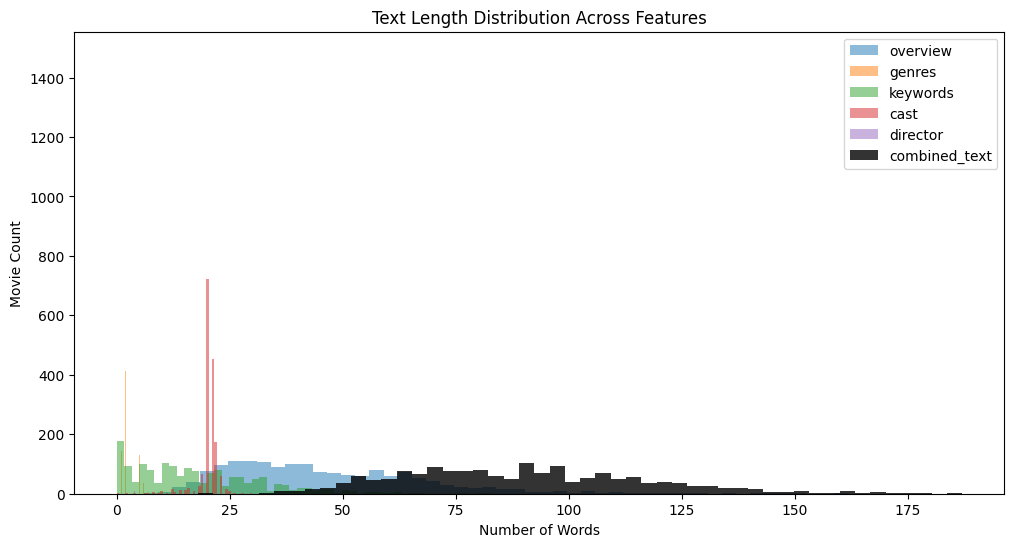

In [10]:
import matplotlib.pyplot as plt

cols = ["overview", "genres", "keywords", "cast", "director"]

# Calculate word counts
for col in cols:
    df[col + "_len"] = df[col].fillna("").apply(lambda x: len(x.split()))

df["combined_len"] = (
    df["overview"].fillna("") + " " +
    df["genres"].fillna("") + " " +
    df["keywords"].fillna("") + " " +
    df["cast"].fillna("") + " " +
    df["director"].fillna("")
).apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(12, 6))
for col in cols:
    plt.hist(df[col + "_len"], bins=50, alpha=0.5, label=col)

plt.hist(df["combined_len"], bins=50, alpha=0.8, label="combined_text", color="black")
plt.legend()
plt.xlabel("Number of Words")
plt.ylabel("Movie Count")
plt.title("Text Length Distribution Across Features")
plt.show()


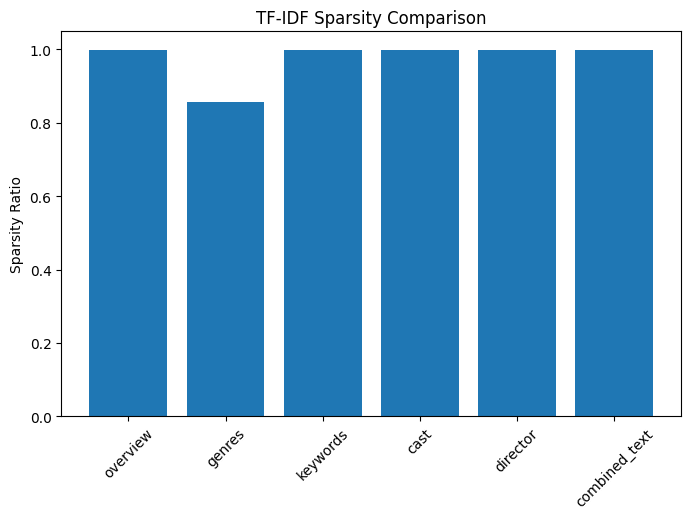

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def compute_sparsity(text):
    tfidf = TfidfVectorizer(stop_words="english")
    X = tfidf.fit_transform(text)
    return 1 - (X.count_nonzero() / (X.shape[0] * X.shape[1]))

features = cols + ["combined_text"]
texts = [df[c].fillna("") if c != "combined_text" else df["combined_text"] for c in features]

sparsities = [compute_sparsity(t) for t in texts]

plt.figure(figsize=(8, 5))
plt.bar(features, sparsities)
plt.ylabel("Sparsity Ratio")
plt.title("TF-IDF Sparsity Comparison")
plt.xticks(rotation=45)
plt.show()


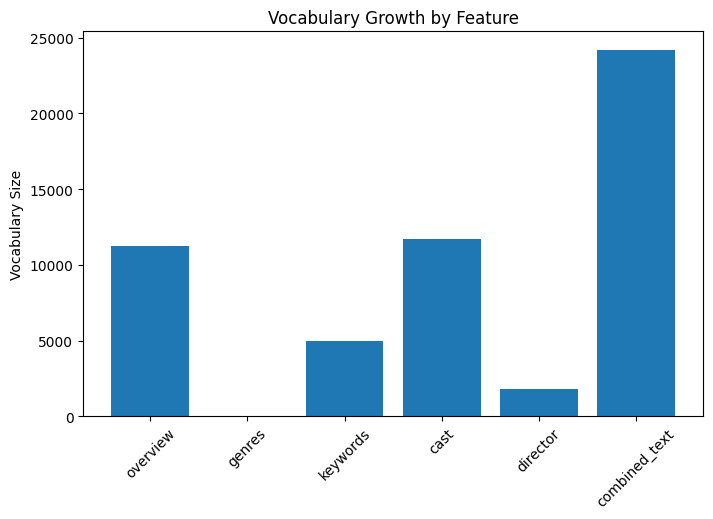

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def vocab_size(text):
    vec = CountVectorizer(stop_words="english")
    vec.fit(text)
    return len(vec.vocabulary_)

vocab_sizes = [
    vocab_size(df[c].fillna("")) if c != "combined_text" else vocab_size(df["combined_text"])
    for c in features
]

plt.figure(figsize=(8, 5))
plt.bar(features, vocab_sizes)
plt.ylabel("Vocabulary Size")
plt.title("Vocabulary Growth by Feature")
plt.xticks(rotation=45)
plt.show()


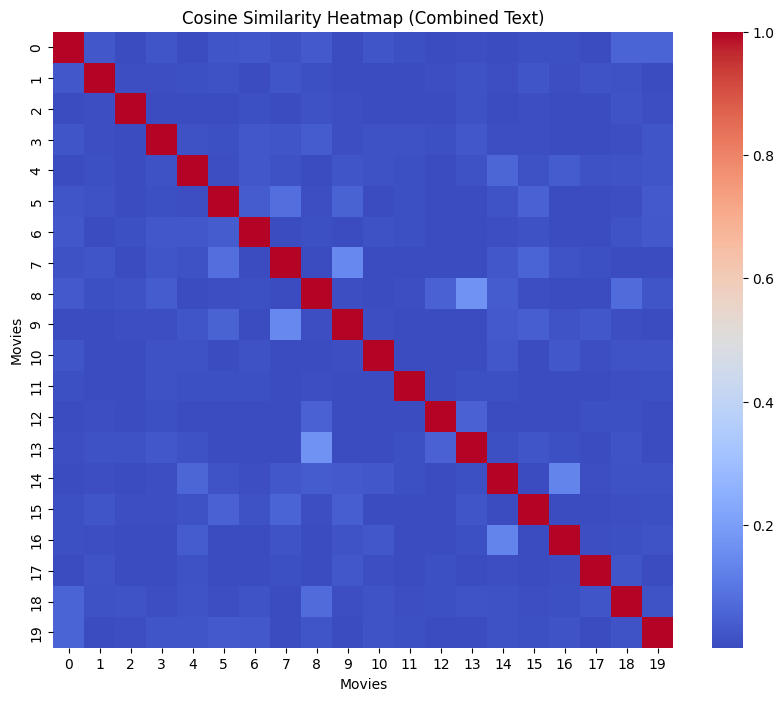

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(df["combined_text"])

# Use subset for visualization
subset = cosine_similarity(X[:20])

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap="coolwarm")
plt.title("Cosine Similarity Heatmap (Combined Text)")
plt.xlabel("Movies")
plt.ylabel("Movies")
plt.show()


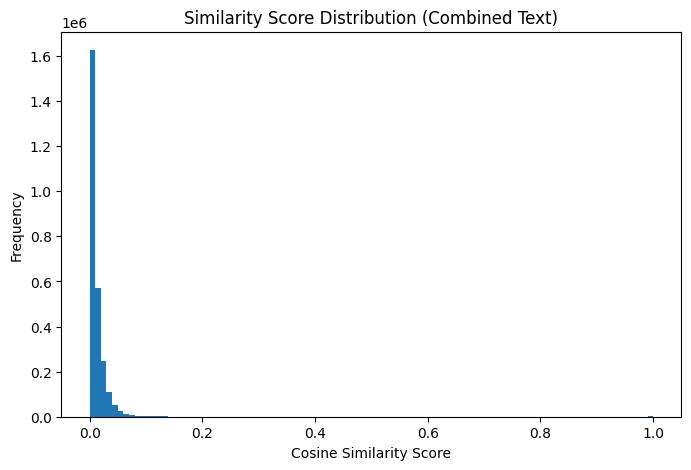

In [14]:
sim_scores = cosine_similarity(X).flatten()

plt.figure(figsize=(8, 5))
plt.hist(sim_scores, bins=100)
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Similarity Score Distribution (Combined Text)")
plt.show()


In [30]:
df["combined_text"]

,combined_text
0,A highly sophisticated Program called Ares is ...
1,When a dangerous new troll unleashes devastati...
2,"During the Kadamba reign, King Vijayendra, the..."
3,Set during the opening days of World War II on...
4,An ex-black ops team reunite to pull off a des...
...,...
1630,"In the ruins of a strange city, a young girl t..."
1631,"A passionate telling of the story of Sada Abe,..."
1632,"A young witch, on her mandatory year of indepe..."
1633,An elite salaryman drunkenly tries to die by s...


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df["combined_text"])

tfidf_matrix.shape


(1635, 5000)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape


(1635, 1635)

In [19]:
from difflib import SequenceMatcher

def seq_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

def jaccard(a_tokens, b_tokens):
    A, B = set(a_tokens), set(b_tokens)
    if not A or not B:
        return 0
    return len(A & B) / len(A | B)

df["title_tokens"] = df["title_norm"].apply(lambda t: t.split())

def find_movie(query):
    q = normalize_text(query)
    q_tokens = q.split()

    # -----------------------------------------
    # SPECIAL CASE: short titles (length <= 4)
    # -----------------------------------------
    if len(q) <= 4:
        # 1. exact normalized match
        exact = df[df["title_norm"] == q]
        if len(exact) > 0:
            return exact["title"].iloc[0]

        # 2. substring match (VERY STRONG)
        sub = df[df["title_norm"].str.contains(q)]
        if len(sub) > 0:
            # pick most popular movie
            return sub.sort_values("vote_count", ascending=False)["title"].iloc[0]

        # 3. prefix match
        pre = df[df["title_norm"].str.startswith(q)]
        if len(pre) > 0:
            return pre.sort_values("vote_count", ascending=False)["title"].iloc[0]

        # 4. last fallback: fuzzy on short titles
        best_title = None
        best_score = 0

        for _, row in df.iterrows():
            t = row["title_norm"]
            score = seq_ratio(q, t)
            if score > best_score:
                best_score = score
                best_title = row["title"]

        return best_title

    # -----------------------------------------
    # MAIN LOGIC for normal-sized titles
    # -----------------------------------------

    # 1. exact match
    exact = df[df["title_norm"] == q]
    if len(exact) > 0:
        return exact["title"].iloc[0]

    # 2. substring match
    sub = df[df["title_norm"].str.contains(q)]
    if len(sub) > 0:
        return sub.sort_values("vote_count", ascending=False)["title"].iloc[0]

    # 3. fuzzy scoring
    best_title = None
    best_score = 0

    for _, row in df.iterrows():
        t = row["title_norm"]
        score = 0.7 * jaccard(q_tokens, row["title_tokens"]) + 0.3 * seq_ratio(q, t)

        if score > best_score:
            best_score = score
            best_title = row["title"]

    return best_title



In [20]:
def recommend(movie_input, top_n=10):
    title = find_movie(movie_input)

    if title is None:
        return f"Movie '{movie_input}' not found."

    print("Matched:", title)

    idx = df.index[df["title"] == title][0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1 : top_n+1]

    movie_indices = [i[0] for i in sim_scores]

    return df.iloc[movie_indices][["title", "genres", "rating", "poster_url"]]


In [21]:
recommend("12th fail")

Matched: 12th Fail


,title,genres,rating,poster_url
1534,Ready,Action Comedy,5.000,https://image.tmdb.org/t/p/w500/umfKMUkXXPfMUo...
1540,Ulajh,Drama Thriller,5.462,https://image.tmdb.org/t/p/w500/tRTaE89m8As6G6...
333,Saiyaara,Romance Drama Music,6.400,https://image.tmdb.org/t/p/w500/hQBIsi3ZfBYEay...
503,Santosh,Crime Drama Thriller,7.045,https://image.tmdb.org/t/p/w500/c4LdJKjE7Du2of...
520,Like Stars on Earth,Drama,7.977,https://image.tmdb.org/t/p/w500/puHRt6Raovm5uj...
524,Naseeb,Drama,7.100,https://image.tmdb.org/t/p/w500/oDUddLemim047H...
1032,Chhaava,History Action Drama,6.894,https://image.tmdb.org/t/p/w500/ubRsrzb6NRW8Yh...
1531,Kick,Action Romance Comedy Crime,5.739,https://image.tmdb.org/t/p/w500/muRGQIGFcHTyHi...
1539,Pad Man,Comedy Drama,7.417,https://image.tmdb.org/t/p/w500/guI9SEqpZ6A0mh...
499,Dada,Drama Comedy Romance,7.438,https://image.tmdb.org/t/p/w500/x7C2u4oXoMFQBa...


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluate_recommender(k=10):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    n = len(df)

    for idx in range(n):
        # TRUE SIMILAR MOVIES (top K from cosine_sim)
        true_scores = list(enumerate(cosine_sim[idx]))
        true_scores = sorted(true_scores, key=lambda x: x[1], reverse=True)[1:k+1]
        true_indices = [i[0] for i in true_scores]

        # MODEL PREDICTED MOVIES
        title = df.iloc[idx]["title"]
        pred_df = recommend(title, top_n=k)

        if isinstance(pred_df, str):
            continue

        pred_titles = pred_df["title"].tolist()
        pred_indices = [df.index[df["title"] == t][0] for t in pred_titles]

        # BUILD BINARY VECTORS
        true_vec = np.zeros(n)
        pred_vec = np.zeros(n)

        true_vec[true_indices] = 1
        pred_vec[pred_indices] = 1

        # ACCUMULATE RESULTS
        true_positive += np.sum((true_vec == 1) & (pred_vec == 1))
        false_positive += np.sum((true_vec == 0) & (pred_vec == 1))
        false_negative += np.sum((true_vec == 1) & (pred_vec == 0))

    # CALCULATE METRICS
    precision = true_positive / (true_positive + false_positive + 1e-6)
    recall = true_positive / (true_positive + false_negative + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    print("Precision@{}: {:.4f}".format(k, precision))
    print("Recall@{}: {:.4f}".format(k, recall))
    print("F1-score@{}: {:.4f}".format(k, f1))

    return precision, recall, f1


In [23]:
evaluate_recommender(k=10)


Matched: TRON: Ares
Matched: Troll 2
Matched: Kantara - A Legend: Chapter 1
Matched: First Squad: The Moment of Truth
Matched: Wildcat
Matched: Bureau 749
Matched: Predator: Badlands
Matched: The Shadow's Edge
Matched: Chainsaw Man - The Movie: Reze Arc
Matched: High Forces
Matched: The Family Plan 2
Matched: Altered
Matched: JUJUTSU KAISEN: Execution -Shibuya Incident x The Culling Game Begins-
Matched: Demon Slayer: Kimetsu no Yaiba Infinity Castle
Matched: She Rides Shotgun
Matched: A Legend
Matched: One Battle After Another
Matched: Art of Eight Limbs
Matched: Mission: Impossible - The Final Reckoning
Matched: The Fantastic 4: First Steps
Matched: Playdate
Matched: High Ground
Matched: Dhurandhar
Matched: Superman
Matched: xXx
Matched: Jurassic World Rebirth
Matched: The Prosecutor
Matched: Sisu: Road to Revenge
Matched: Stand Your Ground
Matched: The Gentleman
Matched: F1
Matched: The Avengers
Matched: Operation Blood Hunt
Matched: Avatar
Matched: The Storm
Matched: Beast of War
M

(np.float64(0.9999999999388379),
 np.float64(0.9999999999388379),
 np.float64(0.999999499939088))

In [24]:
def genre_precision_at_k(k=10):
    total = 0
    match = 0

    for idx in range(len(df)):
        title = df.iloc[idx]["title"]
        genres = set(df.iloc[idx]["genres"].split())

        preds = recommend(title, top_n=k)
        if isinstance(preds, str):
            continue

        for _, row in preds.iterrows():
            total += 1
            rec_genres = set(row["genres"].split())
            if len(genres & rec_genres) > 0:
                match += 1

    precision = match / total
    print(f"Genre Precision@{k}: {precision:.4f}")
    return precision


In [25]:
genre_precision_at_k(10)


Matched: TRON: Ares
Matched: Troll 2
Matched: Kantara - A Legend: Chapter 1
Matched: First Squad: The Moment of Truth
Matched: Wildcat
Matched: Bureau 749
Matched: Predator: Badlands
Matched: The Shadow's Edge
Matched: Chainsaw Man - The Movie: Reze Arc
Matched: High Forces
Matched: The Family Plan 2
Matched: Altered
Matched: JUJUTSU KAISEN: Execution -Shibuya Incident x The Culling Game Begins-
Matched: Demon Slayer: Kimetsu no Yaiba Infinity Castle
Matched: She Rides Shotgun
Matched: A Legend
Matched: One Battle After Another
Matched: Art of Eight Limbs
Matched: Mission: Impossible - The Final Reckoning
Matched: The Fantastic 4: First Steps
Matched: Playdate
Matched: High Ground
Matched: Dhurandhar
Matched: Superman
Matched: xXx
Matched: Jurassic World Rebirth
Matched: The Prosecutor
Matched: Sisu: Road to Revenge
Matched: Stand Your Ground
Matched: The Gentleman
Matched: F1
Matched: The Avengers
Matched: Operation Blood Hunt
Matched: Avatar
Matched: The Storm
Matched: Beast of War
M

0.814006116207951

In [26]:
recommend("Avatar", top_n=10)


Matched: Avatar


,title,genres,rating,poster_url
590,Avatar: Fire and Ash,Science Fiction Adventure Fantasy,7.300,https://image.tmdb.org/t/p/w500/g96wHxU7EnoIFw...
39,Avatar: The Way of Water,Action Adventure Science Fiction,7.600,https://image.tmdb.org/t/p/w500/t6HIqrRAclMCA6...
1300,Aliens,Action Thriller Science Fiction,7.955,https://image.tmdb.org/t/p/w500/r1x5JGpyqZU8PY...
327,Alien,Horror Science Fiction,8.200,https://image.tmdb.org/t/p/w500/vfrQk5IPloGg1v...
824,Capturing Avatar,Documentary,7.000,https://image.tmdb.org/t/p/w500/26SMEXJl3978dn...
1051,Alien³,Science Fiction Action Horror,6.375,https://image.tmdb.org/t/p/w500/xh5wI0UoW7DfS1...
322,Alien: Romulus,Horror Science Fiction,7.176,https://image.tmdb.org/t/p/w500/2uSWRTtCG336nu...
828,Avatar: The Deep Dive - A Special Edition of 2...,Documentary,7.100,https://image.tmdb.org/t/p/w500/pzZGqIyrrSqIfr...
612,Mickey 17,Science Fiction Comedy Adventure,6.829,https://image.tmdb.org/t/p/w500/edKpE9B5qN3e55...
589,Planet of the Apes,Thriller Science Fiction Action Adventure,5.764,https://image.tmdb.org/t/p/w500/eEsOgbgKXMvI2F...


In [27]:
recommend("Bahubali", top_n=10)

Matched: Bāhubali: The Beginning


,title,genres,rating,poster_url
1526,Bāhubali 2: The Conclusion,Action Adventure Fantasy,7.455,https://image.tmdb.org/t/p/w500/21sC2assImQIYC...
1532,Chennai Express,Romance Comedy Action,6.500,https://image.tmdb.org/t/p/w500/9j7XfhBJKNfidM...
1140,The Magic Flute,Music Romance Fantasy,7.191,https://image.tmdb.org/t/p/w500/3N0L2ijwcVjRLJ...
1533,Elaan,Drama Action Thriller,5.600,https://image.tmdb.org/t/p/w500/1Mc56afI0xM6Yt...
497,Kantara,Action Drama Thriller,7.161,https://image.tmdb.org/t/p/w500/jIsKmkxMzdCZ0U...
2,Kantara - A Legend: Chapter 1,Action Drama Fantasy,6.957,https://image.tmdb.org/t/p/w500/zBvw25afDn93em...
514,Fighter,Action Drama,6.125,https://image.tmdb.org/t/p/w500/zqFuriKJ6pYDvf...
498,War 2,Action Adventure Thriller,5.644,https://image.tmdb.org/t/p/w500/2Yc8Kl2ldPpDzL...
1539,Pad Man,Comedy Drama,7.417,https://image.tmdb.org/t/p/w500/guI9SEqpZ6A0mh...
1369,The Drum,Adventure War,5.900,https://image.tmdb.org/t/p/w500/7Opkwzeohwz2II...


In [28]:
recommend("spiderman", top_n=10)

Matched: Spider-Man


,title,genres,rating,poster_url
1291,Spider-Man 3,Action Adventure Science Fiction,6.448,https://image.tmdb.org/t/p/w500/qFmwhVUoUSXjkK...
103,Spider-Man: Across the Spider-Verse,Animation Action Adventure Science Fiction,8.300,https://image.tmdb.org/t/p/w500/8Vt6mWEReuy4Of...
409,Spider-Man: No Way Home,Action Adventure Science Fiction,7.936,https://image.tmdb.org/t/p/w500/1g0dhYtq4irTY1...
614,The Amazing Spider-Man,Action Adventure Science Fiction,6.724,https://image.tmdb.org/t/p/w500/jexoNYnPd6vVrm...
566,Spider-Man: Into the Spider-Verse,Animation Action Adventure Science Fiction,8.395,https://image.tmdb.org/t/p/w500/iiZZdoQBEYBv6i...
415,Spider-Man: Homecoming,Action Adventure Science Fiction,7.300,https://image.tmdb.org/t/p/w500/c24sv2weTHPsmD...
1301,The Amazing Spider-Man 2,Action Adventure Science Fiction,6.525,https://image.tmdb.org/t/p/w500/dGjoPttcbKR5VW...
65,The Bad Guys 2,Family Comedy Crime Adventure Animation,7.700,https://image.tmdb.org/t/p/w500/c1msaKf1wyuKcm...
564,Batman Begins,Drama Crime Action,7.719,https://image.tmdb.org/t/p/w500/sPX89Td70IDDjV...
766,Kick-Ass,Action Crime,7.122,https://image.tmdb.org/t/p/w500/iHMbrTHJwocsNv...


In [29]:
recommend("Batman", top_n=10)

Matched: Batman Begins


,title,genres,rating,poster_url
151,The Dark Knight,Drama Action Crime Thriller,8.525,https://image.tmdb.org/t/p/w500/qJ2tW6WMUDux91...
565,The Dark Knight Rises,Action Crime Drama Thriller,7.790,https://image.tmdb.org/t/p/w500/hr0L2aueqlP2BY...
182,The Batman,Crime Mystery Thriller,7.660,https://image.tmdb.org/t/p/w500/74xTEgt7R36Fpo...
766,Kick-Ass,Action Crime,7.122,https://image.tmdb.org/t/p/w500/iHMbrTHJwocsNv...
409,Spider-Man: No Way Home,Action Adventure Science Fiction,7.936,https://image.tmdb.org/t/p/w500/1g0dhYtq4irTY1...
568,Batman v Superman: Dawn of Justice,Action Adventure Fantasy,5.988,https://image.tmdb.org/t/p/w500/5UsK3grJvtQrtz...
587,Spider-Man,Action Science Fiction,7.318,https://image.tmdb.org/t/p/w500/gh4cZbhZxyTbgx...
767,Léon: The Professional,Crime Drama Action,8.299,https://image.tmdb.org/t/p/w500/bxB2q91nKYp8JN...
1615,Dragon Ball Z: Broly - The Legendary Super Saiyan,Animation Science Fiction Action,7.212,https://image.tmdb.org/t/p/w500/6iO8TJCyLI4BiP...
54,Inception,Action Science Fiction Adventure,8.371,https://image.tmdb.org/t/p/w500/xlaY2zyzMfkhk0...
